In [1]:
%load_ext autoreload

In [2]:
import random, numpy.random
SEED = 101

In [3]:
random.seed(SEED)
numpy.random.seed(SEED)

In [4]:
%autoreload
%matplotlib inline
import os, shutil, matplotlib, matplotlib.pyplot as plt, pandas as pd, tensorflow as tf, numpy as np
import ml_toolkit.tensorflow_constructions as tfc

from matplotlib import animation, rc
from IPython.display import HTML

from CWRGAN.translator_wgan import TranslatorWGAN
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15, 15)
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['animation.html'] = 'html5'
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [6]:
BASE_DIR = 'output'
if not os.path.isdir(BASE_DIR): os.mkdir(BASE_DIR)

In [7]:
def columns(d): return (d.iloc[:, 0], d.iloc[:, 1]) if type(d) is pd.DataFrame else (d[:, 0], d[:, 1])

In [8]:
def build_model(
    source_data,
    target_data,
    joint = False,
    opts = None,
    exp_dir = BASE_DIR,
    model_name = '',
    reset=True,
    clear_dir=False,
): 
    siil = []
    assert model_name != '', "Must provide a model name."
    if reset: tf.reset_default_graph()

    save_dir = os.path.join(exp_dir, model_name)
    
    print("Saving model to", save_dir)
    if clear_dir and os.path.isdir(save_dir): shutil.rmtree(save_dir)
    if not os.path.isdir(save_dir): os.mkdir(save_dir)
        
    source_paired, source_unpaired, source_test = source_data                                          
    target_paired, target_unpaired, target_test = target_data
    
    side_info_paired = None                                                      
    side_info_source_unpaired = None                                           
    side_info_target_unpaired = None                                           
    side_info_test = None                                                          
    return TranslatorWGAN(                                                                                    
        source_paired_df             = source_paired,                                                      
        target_paired_df             = target_paired,                                                      
        source_unpaired_df           = source_unpaired if joint else source_unpaired.iloc[0:0],            
        target_unpaired_df           = target_unpaired if joint else target_unpaired.iloc[0:0],            
        side_info_paired_df          = side_info_paired,                                                   
        side_info_source_unpaired_df = side_info_source_unpaired if joint else None,                       
        side_info_target_unpaired_df = side_info_target_unpaired if joint else None,                       
        save_dir                     = save_dir,                                                           
        **opts                                                                                          
    )                                                                                                      

In [9]:
def plot_data(source_data, target_data, only_paired=False):
    source_paired, source_unpaired, source_test = source_data
    target_paired, target_unpaired, target_test = target_data
    
    handles, labels = [], []
    handles.append(plt.scatter(*columns(source_paired), color='r')); labels.append('Source Paired')
    handles.append(plt.scatter(*columns(target_paired), color='b')); labels.append('Target Paired')
    if not only_paired:
        handles.append(plt.scatter(*columns(source_unpaired), color='r', marker='^', alpha=0.01))
        handles.append(plt.scatter(*columns(target_unpaired), color='b', marker='^', alpha=0.01))
        labels += ['Source Unpaired', 'Target Unpaired']
    
    plt.xlim([-2, 8])
    plt.ylim([-2, 8])
    plt.legend(handles, labels)
    plt.show()

In [10]:
def make_feed(m, d=None, X=None, Y=None, paired=True):
    assert (d is not None) or (X is not None and Y is not None), "Must provide valid data!"
    if d is None: d = [np.array([x, y]).reshape([2, -1]).T for x, y in zip(X, Y)]
    #print "Source shape: ", d[0].shape, "Target Shape: ", d[1].shape
    return {
        m.source_paired: d[0] if paired else np.empty((0, 2)),
        m.target_paired: d[1] if paired else np.empty((0, 2)),
        m.source_unpaired: np.empty((0, 2)) if paired else d[0],
        m.target_unpaired: np.empty((0, 2)) if paired else d[1],
        m.side_info_paired:np.empty((len(d[0]), 0)) if paired else np.empty((0, 0)),
        m.side_info_source_unpaired: np.empty((0, 0)) if paired else np.empty((len(d[0]), 0)),
        m.side_info_target_unpaired: np.empty((0, 0)) if paired else np.empty((len(d[1]), 0)),
        m.critic_dropout_keep_prob: 1.0,
        m.training: False,
    }

In [11]:
def eval_var(m, vs, f=None):
    return m.sess.run([m.graph.get_tensor_by_name(v.name) for v in vs], feed_dict=m.feed() if f is None else f)

In [12]:
def plot_critic(source_data, target_data, m, source=False):
    source_paired, source_unpaired, source_test = source_data
    target_paired, target_unpaired, target_test = target_data
    
    delta = 0.01
    x = np.arange(-2, 8, delta)
    y = np.arange(-2, 8, delta)
    X, Y = np.meshgrid(x, y)
    feed_dict = make_feed(m, X=(X, X), Y=(Y, Y))
    source_critic, target_critic = eval_var(m, [m.C_source_real, m.C_target_real], f=feed_dict)
    source_critic, target_critic = map(lambda s: s.reshape(X.shape), [source_critic, target_critic])

    # Create a simple contour plot with labels using default colors.  The
    # inline argument to clabel will control whether the labels are draw
    # over the line segments of the contour, removing the lines beneath
    # the label
    if source: SCS = plt.contour(X, Y, source_critic)
    else: TCS = plt.contour(X, Y, target_critic)
    if source: plt.clabel(SCS, inline=1, fontsize=10)
    else: plt.clabel(TCS, inline=1, fontsize=10)
    
    if source:
        paired_handle = plt.scatter(*columns(source_paired), color='r')
        unpaired_handle = plt.scatter(*columns(source_unpaired), color='r', marker='^', alpha=0.01)
    else:
        paired_handle = plt.scatter(*columns(target_paired), color='b')
        unpaired_handle = plt.scatter(*columns(target_unpaired), color='b', marker='^', alpha=0.01)

    plt.legend(
        #[source_paired_handle, target_paired_handle, source_unpaired_handle, target_unpaired_handle],
        [paired_handle, unpaired_handle],
        #['Source Paired', 'Target Paired', 'Source Unpaired', 'Target Unpaired'])
        ['Paired', 'Unpaired']
    )
    plt.xlim([-2, 8])
    plt.ylim([-2, 8])
    plt.show()

In [13]:
def plot_predictions(source_data, target_data, m=None,
                     plot_target_predictions=False, plot_source_predictions=True, model_name=''):
    source_paired, source_unpaired, source_test = source_data
    target_paired, target_unpaired, target_test = target_data
    
    source_joint = pd.concat([source_paired, source_unpaired])
    target_joint = pd.concat([target_paired, target_unpaired])

    if type(m) == TranslatorWGAN:
        predictions_of_source, predictions_of_target, cycle_source, cycle_target = \
                            eval_var(m, [m.F_source, m.G_target, m.G_F_source, m.F_G_target],
                                         f=make_feed(m, d=(source_joint, target_joint)))
    else:
        predictions_of_source = m.predict(pd.concat([source_paired, source_unpaired]))

    handles, labels = [], []
    handles.append(plt.scatter(*columns(pd.concat([source_paired, source_unpaired])), color='r'))
    labels.append('Source')
    handles.append(plt.scatter(*columns(pd.concat([target_paired, target_unpaired])), color='b'))
    labels.append('Target')
    if plot_source_predictions: 
        handles.append(plt.scatter(*columns(predictions_of_source), color='g', marker='*', alpha=1))
        labels.append('Source Predictions (overall)')
    if plot_target_predictions and type(m) == TranslatorWGAN:
        handles.append(plt.scatter(*columns(predictions_of_target), color='y', marker='*', alpha=1))
        labels.append('Target Predictions (overall)')
    if plot_source_predictions: 
        handles.append(plt.scatter(*columns(cycle_source), color='k', marker='*', alpha=1))
        labels.append('Source Cycle (overall)')
    if plot_target_predictions and type(m) == TranslatorWGAN:
        handles.append(plt.scatter(*columns(cycle_target), color='m', marker='*', alpha=1))
        labels.append('Target Cycle (overall)')
        
    plt.legend(handles, labels)
    plt.xlim([-2, 8])
    plt.ylim([-2, 8])
    plt.show()
    plt.savefig(model_name + '.png')

In [14]:
def eval_model(source_data, target_data, m=None, pfx='', model_name = ''):
    source_paired, source_unpaired, source_test = source_data
    target_paired, target_unpaired, target_test = target_data

    if type(m) == TranslatorWGAN:
        predictions_of_source, cycle_source, cycle_target = eval_var(
            m, [m.F_source, m.G_F_source, m.F_G_target], f=make_feed(m, d=(source_test, target_test))
        )#[0]
        #predictions_of_target = eval_var(m, [m.G_target])[0]
        cycle_x = np.mean(np.linalg.norm(cycle_source - source_test, axis=1))
        cycle_y = np.mean(np.linalg.norm(cycle_target - target_test, axis=1))
        extra = ' {} {}'.format(cycle_x, cycle_y)        
    else:
        extra = ', R² = %.2f' % m.score(source_paired, target_paired)
        predictions_of_source = m.predict(source_test)
    
    print('%sEuclidean Loss: %.2f%s' % (
        pfx + ': ' if pfx != '' else '',
        np.mean(
            np.linalg.norm(predictions_of_source - target_test.values, axis=1)
        ),
        extra
    ))
    
    plot_predictions(source_data, target_data, m, plot_target_predictions=True, model_name=model_name)
   

In [15]:
def plt_data(data, ax, color='b', marker='o', alpha=0.02):
    all_data = pd.concat(data)
    extent = all_data.max().max() - all_data.min().min()
    center = all_data.mean()
    
    ax.set_xlim((center[0] - extent/2. - 0.7, center[0] + extent/2. + 0.7))
    ax.set_ylim((center[1] - extent/2. - 0.7, center[1] + extent/2. + 0.7))
    ax.axis('equal')
    return ax.scatter(*columns(all_data), color=color, marker=marker, alpha=alpha)

def animate(
    source_data,
    target_data,
    model_opts,
    source_color='r',
    target_color='b',
    model_name = 'animation',
    step_size = 2,
    total_steps = 480,
    grid_delta = 0.01,
    interval=10,
    joint=True
):
    opts = model_opts.copy()
    opts['print_anything'] = False
    m = build_model(source_data, target_data, model_name=model_name,
                    opts=opts, clear_dir=True, joint=joint)

        

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    source_ax = plt.subplot('121')
    target_ax = plt.subplot('122')
    source_ax.set_title('Source')
    target_ax.set_title('Target')

    src_data_hdl = plt_data(source_data, source_ax)
    target_data_hdl = plt_data(target_data, target_ax)
    
    data_feed = make_feed(m, d=(pd.concat(source_data), pd.concat(target_data)))

    predictions_of_source, predictions_of_target = eval_var(m, [m.F_source, m.G_target], f=data_feed)

    source_predictions_hdl, = target_ax.plot(*columns(predictions_of_source), color='r', marker='o', alpha=0.02)
    target_predictions_hdl, = source_ax.plot(*columns(predictions_of_target), color='r', marker='o', alpha=0.02)
   
    source_grid = np.meshgrid(np.arange(*source_ax.get_xlim(), step=grid_delta),
                              np.arange(*source_ax.get_ylim(), step=grid_delta))
    target_grid = np.meshgrid(np.arange(*target_ax.get_xlim(), step=grid_delta),
                              np.arange(*target_ax.get_ylim(), step=grid_delta))
    grid_feed = make_feed(m, X=(source_grid[0], target_grid[0]), Y=(source_grid[1], target_grid[1]), paired=False)
    source_critic, target_critic = eval_var(m, [m.C_source_real, m.C_target_real], f=grid_feed)
    animate.source_contour_hdl = source_ax.contour(source_grid[0], source_grid[1],
                                            source_critic.reshape(source_grid[0].shape), 20)
    animate.target_contour_hdl = target_ax.contour(target_grid[0], target_grid[1],
                                            target_critic.reshape(target_grid[0].shape), 20)

    source_predictions, target_predictions, source_critic_grid, target_critic_grid = [], [], [], []
    for epoch in range(total_steps):
        if epoch % step_size == 0:
            print('Recording epoch %d' % epoch)
            predictions_of_source, predictions_of_target = eval_var(m, [m.F_source, m.G_target], f=data_feed)
            source_critic, target_critic = eval_var(m, [m.C_source_real, m.C_target_real], f=grid_feed)
            
            source_predictions.append(predictions_of_source)
            target_predictions.append(predictions_of_target)
            source_critic_grid.append(source_critic.reshape(source_grid[0].shape))
            target_critic_grid.append(target_critic.reshape(target_grid[0].shape))

        try: translator_loss = m._global_step(0)
        except ValueError:
            print("Value Error!")
            break

    # animation function. This is called sequentially
    def draw_frame(i):
        source_prediction, target_prediction = source_predictions[i], target_predictions[i]
        source_critic, target_critic = source_critic_grid[i], target_critic_grid[i]
        source_predictions_hdl.set_data(*columns(source_prediction))
        target_predictions_hdl.set_data(*columns(target_prediction))
        
        #source_countour_hdl.collections.set_data(source_grid[0], source_grid[1], source_critic)
        #target_countour_hdl.collections.set_data(target_grid[0], target_grid[1], target_critic)
        #global source_contour_hdl, target_contour_hdl
        for c in animate.source_contour_hdl.collections: c.remove()
        for c in animate.target_contour_hdl.collections: c.remove()
        animate.source_contour_hdl = source_ax.contour(source_grid[0], source_grid[1], source_critic, 20)
        animate.target_contour_hdl = target_ax.contour(target_grid[0], target_grid[1], target_critic, 20)

        return source_predictions_hdl, target_predictions_hdl
    
    # call the animator. blit=True means only re-draw the parts that have changed.    
    anim = animation.FuncAnimation(fig, draw_frame, frames=int(np.floor(epoch/step_size)),
                                   interval=interval, blit=True)
    return (source_predictions, target_predictions, source_critic_grid, target_critic_grid), anim

In [16]:
R = np.random.normal(1, 0.01, 10000)
T = np.random.uniform(0, 2*np.pi, 10000)
X = R * np.cos(T)
Y = R * np.sin(T)
source = np.array([X, Y]).T

desired_map = np.array([[0.2, 0], [0, 4]])
desired_bias = np.array([1, 3])

target = np.matmul(source, desired_map) + desired_bias
source_paired, source_unpaired, source_test = source[:8000], np.empty((0, 2)), source[8000:]
target_paired, target_unpaired, target_test = target[:8000], np.empty((0, 2)), target[8000:]
source_data = map(lambda d: pd.DataFrame(d), [source_paired, source_unpaired, source_test])
target_data = map(lambda d: pd.DataFrame(d), [target_paired, target_unpaired, target_test])

In [17]:
def redistribute(source_data, target_data, num_paired_out=3, seed=99):
    source_paired, source_unpaired, source_test = source_data
    target_paired, target_unpaired, target_test = target_data
    index = list(range(len(source_paired) + len(source_unpaired)))
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        np.random.set_state(np.random.RandomState(seed).get_state())
    np.random.shuffle(index)
    source_tot = pd.concat([source_paired, source_unpaired])
    target_tot = pd.concat([target_paired, target_unpaired])
    return (
        (source_tot.iloc[index[:num_paired_out]], source_tot.iloc[index[num_paired_out:]], source_test),
        (target_tot.iloc[index[:num_paired_out]], target_tot.iloc[index[num_paired_out:]], target_test)
    )

In [18]:
source_data_limited, target_data_limited = redistribute(source_data, target_data, num_paired_out=2, seed=102)

In [19]:
source_data_limited[0]

,0,1
408,0.969792,0.243001
6444,-0.930082,0.372368


In [20]:
# Parameters are not necessarilly Optimal.
def translator_learning_rate(step): return tf.train.piecewise_constant(step, [2500, 4000], [1e-2, 5e-4, 1e-5])
OPTIONS = {
    'num_critic_hidden_layers': 3,
    'num_translator_hidden_layers': 0,
    'network_activation': tfc.leaky_relu,
    'max_global_epochs': [3],
    'print_anything': False,
    'train_dropout_keep_prob': 1.0,
    'use_batch_norm': False,
    'adversarial_loss_multipliers': [2],
    'cycle_loss_multipliers': [2],
    'euc_dist_T_loss_multipliers': [10],
    'euc_dist_S_loss_multipliers': [10],
    'dev_size': 0.0,
    'translator_learning_rate': translator_learning_rate,
    'max_global_patiences': [500],
    'batch_size': 10,
    'num_translator_hidden_layers': 0,
    'gradient_loss_multipliers': [3],
    'max_critic_epochs': [5], #7, to vary
    'max_translator_epochs': [1],
    'min_global_epochs':0,
    'L2_regularization_penalties': [0],
    'critic_hidden_dim': 500,
    'config': tf.ConfigProto(
        device_count = {'GPU': 0}
    ),
}

In [21]:
two_paired = build_model(
    source_data_limited,
    target_data_limited,
    model_name = 'test_run',
    opts=OPTIONS,
    joint=True,
    reset=True,
    clear_dir=True
)

Saving model to output/test_run
INFO:tensorflow:Summary name TRANSLATOR_WGAN_translator/S_to_T/translator_layer/weights:0 is illegal; using TRANSLATOR_WGAN_translator/S_to_T/translator_layer/weights_0 instead.
INFO:tensorflow:Summary name TRANSLATOR_WGAN_translator/S_to_T/translator_layer/bias:0 is illegal; using TRANSLATOR_WGAN_translator/S_to_T/translator_layer/bias_0 instead.
INFO:tensorflow:Summary name TRANSLATOR_WGAN_translator/T_to_S/translator_layer/weights:0 is illegal; using TRANSLATOR_WGAN_translator/T_to_S/translator_layer/weights_0 instead.
INFO:tensorflow:Summary name TRANSLATOR_WGAN_translator/T_to_S/translator_layer/bias:0 is illegal; using TRANSLATOR_WGAN_translator/T_to_S/translator_layer/bias_0 instead.
INFO:tensorflow:Summary name TRANSLATOR_WGAN_critic/S_critic/layer_0/weights:0 is illegal; using TRANSLATOR_WGAN_critic/S_critic/layer_0/weights_0 instead.
INFO:tensorflow:Summary name TRANSLATOR_WGAN_critic/S_critic/layer_0/bias:0 is illegal; using TRANSLATOR_WGAN_cr

### Pre-training, Just Random Init:

Euclidean Loss: 4.27 1.985133312540773 7.233429160492733


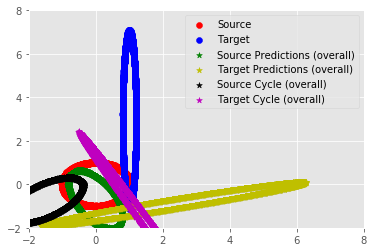

In [22]:
eval_model(source_data_limited, target_data_limited, two_paired)

### After 3 Epochs
After just 3 epochs, the cycle maps have snapped into place, and the paired points (evident in the second plot) are more or less perfectly set, though the overall maps are still poor. 

However, by plotting the critic contour lines in the target domain (second plot) we can see that the critic favors the true shape and thus the adversarial gradients will update the maps towards the correct solution. After many more epochs, this model will converge.

Euclidean Loss: 0.60 0.016850592304909328 0.013145229891192933


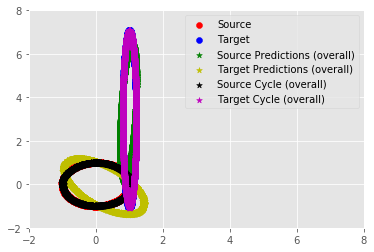

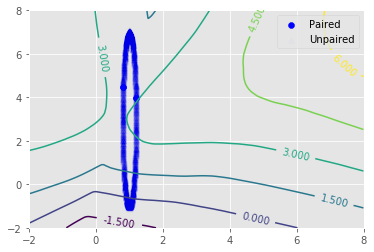

In [23]:
two_paired.train()
eval_model(source_data_limited, target_data_limited, two_paired)
plot_critic(source_data_limited, target_data_limited, two_paired)

After 3 more epochs, we see further growth, the mapping stretching out towards the proper shape. The critic contour lines are a bit confusing here (recall the critic is attempting to give the real data as large a value as possible and the generated data as small a value as possible), but things make more sense if you just focus on the region where the source and the target diverge (the slight bulge of green off of the pink ellipse in the bottom left quadrant of the image). There, the gradient of the critic would point just slightly down and to the right (perpendicular to the contour lines) which, if the generator updates to maximizing the critic's score of the generated data, would push the ellipse to rotate counter-clockwise, as desired. The apparent growth of the critic as we extend out radially is artifactual---the generated points never land that far out, so the critic's values in those regions do not really affect learning.

Euclidean Loss: 0.27 2.782820927112972e-05 5.2632566517197954e-05


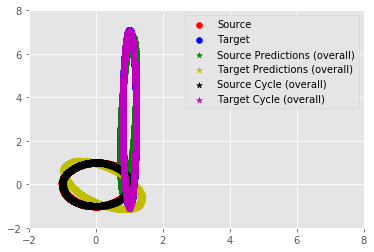

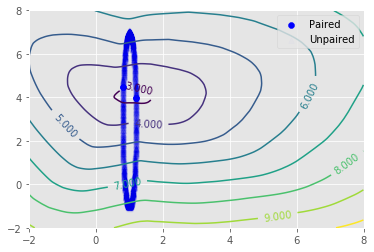

In [24]:
two_paired.train()
eval_model(source_data_limited, target_data_limited, two_paired)
plot_critic(source_data_limited, target_data_limited, two_paired)

After 30 additional epochs, the mapping is closer to optimal. The picture shows minimal difference at this resolution, but the Euclidean loss has fallen by ~16%. Convergence is slow for the adversarial loss, as it is not so direct a learning signal as a standard regression loss, but it pushes the model in the right direction. Again, the critic lines send the right signals in the local region of divergence from the true mapping.

Euclidean Loss: 0.23 1.3756229998446817e-05 2.0379254999657006e-05


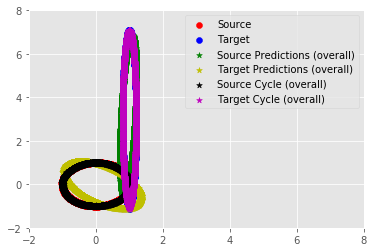

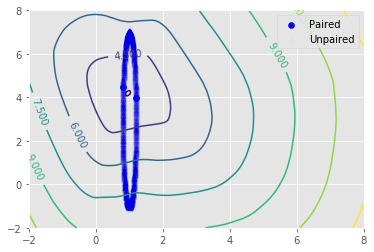

In [25]:
two_paired.max_global_epochs = [30]
two_paired.train()
eval_model(source_data_limited, target_data_limited, two_paired)
plot_critic(source_data_limited, target_data_limited, two_paired)

Were we to run the system for many additional epochs, the adversarial loss would eventually cause the model to converge to the true shape.

In [ ]:
two_paired.max_global_epochs = [200]
two_paired.train()
eval_model(source_data_limited, target_data_limited, two_paired)
plot_critic(source_data_limited, target_data_limited, two_paired)